In [1]:
import pandas as pd
import numpy as np
from src.processer import fragmentSmiles, getSelfiesToks, applyFncPool, getTsmiles, augSmiles, preprocessSmiles
import os

In [2]:
## these smiles data are provided by grisoni github (BIMODAL work)
chemblDataRaw= pd.read_csv('rawdata/chembl_smiles.tar.xz', 
                     compression="xz", skipfooter= 1, engine='python').astype(str).squeeze()

In [3]:
pathData = "data/"

In [4]:
chemblDataRaw.size

677044

In [5]:
chemblData = pd.Series (
    applyFncPool(chemblDataRaw, fnc = preprocessSmiles),
    index=chemblDataRaw.index
)

In [6]:
chemblData.drop_duplicates(keep='first',inplace=True)
chemblData.dropna(inplace=True)

In [7]:
# so many data are discarded. Chirality information is kept
chemblData.size

340301

In [8]:
chemblDataToks = chemblData.to_frame(name='smiles')

In [9]:
chemblDataToks['fragsmiles'] = applyFncPool( chemblData, fnc = fragmentSmiles )

## In order to build a dataset of size comparable to reference work of Grisoni et al., we deciced to analyze length distribution of fragSMILES tokens

In [10]:
length_fragsmiles = chemblDataToks['fragsmiles'].apply(lambda x: len(x.split(' ')))

<AxesSubplot: >

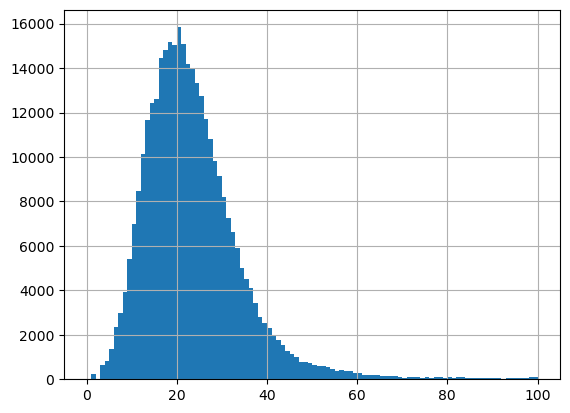

In [11]:
length_fragsmiles.hist(bins=100, range = (0,100))

In [12]:
length_fragsmiles.describe()

count    340301.000000
mean         24.014561
std          16.757076
min           1.000000
25%          16.000000
50%          21.000000
75%          28.000000
max         603.000000
Name: fragsmiles, dtype: float64

In [13]:
## 10-32 is an optim range to obtain ~250K molecules
mask_length_10_32 = (length_fragsmiles >=10) & (length_fragsmiles<=32)

In [14]:
mask_length_10_32.sum()

270408

## build the definitive dataset !

In [15]:
chemblData_10_32 = chemblData[mask_length_10_32]

In [16]:
chemblDataToks_10_32 = chemblDataToks[mask_length_10_32]

In [17]:
chemblDataToks_10_32['selfies'] = applyFncPool(chemblData_10_32, fnc = getSelfiesToks)

/tmp/ipykernel_1822604/917547025.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemblDataToks_10_32['selfies'] = applyFncPool(chemblData_10_32, fnc = getSelfiesToks)


In [18]:
chemblDataToks_10_32['tsmiles'] = applyFncPool(chemblData_10_32, fnc = getTsmiles)

/tmp/ipykernel_1822604/2903495064.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemblDataToks_10_32['tsmiles'] = applyFncPool(chemblData_10_32, fnc = getTsmiles)


In [19]:
chemblDataToks_10_32

,smiles,fragsmiles,selfies,tsmiles
0,CSc1nn(-c2cccc(C)c2)c2cc(C3=CCNCC3)ccc12,C S <6> c1ccc2[nH]ncc2c1 <4> <1> ( <0> C1=CCNC...,[C] [S] [C] [=N] [N] [Branch1] [N] [C] [=C] [C...,*C&*SC1=NN(*)C2=CC(*)=CC=C12&*C1=CC=CC(*)=C1&*...
1,CSc1nn(-c2cccc(F)c2)c2cc(C3=CCNCC3)ccc12,C S <6> c1ccc2[nH]ncc2c1 <4> <1> ( <0> C1=CCNC...,[C] [S] [C] [=N] [N] [Branch1] [N] [C] [=C] [C...,*C&*SC1=NN(*)C2=CC(*)=CC=C12&*C1=CC=CC(*)=C1&*...
2,CSc1nn(-c2ccc(C)cc2)c2cc(C3=CCNCC3)ccc12,C S <6> c1ccc2[nH]ncc2c1 <4> <1> ( <0> C1=CCNC...,[C] [S] [C] [=N] [N] [Branch1] [N] [C] [=C] [C...,*C&*SC1=NN(*)C2=CC(*)=CC=C12&*C1=CC=C(*)C=C1&*...
3,O=C(c1ccc2c(c1)[nH]c(=O)c1cnn(C3CCCC3)c12)N1CC...,Cl <0> c1ccc2c(c1)CCN2 <8> C=O <5> O=c1[nH]c2c...,[O] [=C] [Branch2] [Ring2] [C] [C] [=C] [C] [=...,*C(=O)N1CCC2=CC(*)=CC=C21&*C1=CC=C2C(=C1)NC(=O...
4,Cc1cc2[nH]c(=O)c3cnn(C4CCOCC4)c3c2cc1C(=O)N1CC...,C <5> O=c1[nH]c2ccccc2c2[nH]ncc12 <6> <10> ( <...,[C] [C] [=C] [C] [NH1] [C] [=Branch1] [C] [=O]...,*C&*C1=CC2=C(C=C1*)C1=C(C=NN1*)C(=O)N2&*C(=O)N...
...,...,...,...,...
677034,OC[C@@H]1CCCN1Cc1nc2ccccc2n1Cc1ccc(Cl)cc1,O C <4S> C1CCNC1 <3> C <5> c1ccc2[nH]cnc2c1 <4...,[O] [C] [C@@H1] [C] [C] [C] [N] [Ring1] [Branc...,*O&*C*&*[C@@H]1CCCN1*&*C*&*C1=NC2=CC=CC=C2N1*&...
677035,Cc1ccc2nc(CN3CCCC3)n(Cc3ccc(Cl)cc3)c2c1,C1CCNC1 <3> C <5> c1ccc2[nH]cnc2c1 <4> <1> ( C...,[C] [C] [=C] [C] [=C] [N] [=C] [Branch1] [=Bra...,*C&*C1=CC=C2N=C(*)N(*)C2=C1&*C*&*N1CCCC1^*C*&&...
677041,NC1=NC2(c3cc(-c4cncnc4)ccc3OCC23CC3)C(F)(F)CS1,c1cncnc1 <0> <8> C1=NC2(CCS1)c1ccccc1OCC21CC1 ...,[N] [C] [=N] [C] [Branch2] [Ring1] [N] [C] [=C...,*C1=CC=C2OCC3(CC3)C3(N=C(N)SCC3(*)F)C2=C1&*C1=...
677042,CS(=O)(=O)Nc1ccc(OC[C@@H](O)CN2CCN(c3ccc(Cl)cc...,Cl <3> c1ccccc1 <0> <5> C1CNCCN1 <2> C C|S ( O...,[C] [S] [=Branch1] [C] [=O] [=Branch1] [C] [=O...,*C&*S(=O)(=O)N*&*C1=CC=C(*)C=C1&*O*&*C*&*[C@@H...


## saving

In [20]:
from sklearn.model_selection import KFold

kf=KFold(n_splits=5, shuffle=True, random_state=0)

indexes = chemblDataToks_10_32.index.unique()

In [21]:
def tabular_fold_idxs(indexes, splitting_object):

    df = pd.DataFrame(index=indexes)    

    kf = splitting_object.split( indexes )

    for fold,(trainIdx,validIdx) in enumerate(kf):
        df[f'fold{fold}'] = None
        df.iloc[trainIdx,fold] = 'train'
        df.iloc[validIdx,fold] = 'valid'

    return df

In [22]:
split_df = tabular_fold_idxs(indexes=indexes, splitting_object=kf)

In [23]:
split_df

,fold0,fold1,fold2,fold3,fold4
0,train,valid,train,train,train
1,train,train,train,valid,train
2,train,train,train,train,valid
3,train,train,valid,train,train
4,train,train,train,valid,train
...,...,...,...,...,...
677034,train,valid,train,train,train
677035,train,train,valid,train,train
677041,valid,train,train,train,train
677042,valid,train,train,train,train


In [24]:
datafile = pd.concat([chemblDataToks_10_32, split_df], axis=1, ignore_index=False)

In [25]:
datafile.to_csv(os.path.join(pathData,"chembl.tar.xz"), compression="xz", index=False)

## Let's augment dataset !

In [26]:
from functools import partial

In [52]:
chemblAug5DataToks_10_32 = pd.DataFrame(index=chemblData_10_32.index)

In [53]:
chemblAug5DataToks_10_32['smiles']=applyFncPool(chemblData_10_32, fnc = augSmiles)

In [54]:
fragmentSmilesAug5 = partial(fragmentSmiles, aug=5)

In [55]:
chemblAug5DataToks_10_32['fragsmiles']=applyFncPool(chemblData_10_32, fnc = fragmentSmilesAug5)

In [56]:
chemblAug5DataToks_10_32 = chemblAug5DataToks_10_32.explode(['smiles','fragsmiles'])

In [51]:
chemblAug5DataToks_10_32[chemblAug5DataToks_10_32.isna().any(axis=1)]

,smiles,fragsmiles
3,n1cc2c([nH]c3cc(C(=O)N4c5c(cc(cc5)Cl)CC4)ccc3c...,None
3,C(N1c2ccc(Cl)cc2CC1)(=O)c1ccc2c3n(ncc3c(=O)[nH...,None
3,c1cc2c3c(cnn3C3CCCC3)c([nH]c2cc1C(=O)N1c2c(CC1...,None
6,C1(CCOCC1)n1ncc2c([nH]c3c(ccc(c3)C(=O)N3CCc4c3...,None
6,c1nn(C2CCOCC2)c2c3ccc(C(N4CCc5cc(Cl)ccc45)=O)c...,None
...,...,...
677033,c1c(ccc(Cl)c1)Cn1c2c(nc1CN1CCCC1)cccc2,None
677033,C(N1CCCC1)c1nc2ccccc2n1Cc1ccc(Cl)cc1,None
677034,OC[C@H]1N(CCC1)Cc1nc2ccccc2n1Cc1ccc(cc1)Cl,None
677034,c1(nc2ccccc2n1Cc1ccc(Cl)cc1)CN1CCC[C@H]1CO,None


In [57]:
chemblAug5DataToks_10_32['selfies'] = applyFncPool(chemblAug5DataToks_10_32['smiles'], fnc = getSelfiesToks)

In [58]:
chemblAug5DataToks_10_32['tsmiles'] = applyFncPool(chemblAug5DataToks_10_32['smiles'], fnc = getTsmiles)

In [60]:
chemblAug5DataToks_10_32

,smiles,fragsmiles,selfies,tsmiles
0,CSc1nn(-c2cccc(C)c2)c2cc(C3=CCNCC3)ccc12,C S <6> c1ccc2[nH]ncc2c1 <4> <1> ( <0> C1=CCNC...,[C] [S] [C] [=N] [N] [Branch1] [N] [C] [=C] [C...,*C&*SC1=NN(*)C2=CC(*)=CC=C12&*C1=CC=CC(*)=C1&*...
0,c1ccc(C)cc1-n1c2c(ccc(C3CCNCC=3)c2)c(n1)SC,C <4> c1ccccc1 <0> <4> c1ccc2[nH]ncc2c1 <6> <1...,[C] [=C] [C] [=C] [Branch1] [C] [C] [C] [=C] [...,*C&*SC1=NN(*)C2=CC(*)=CC=C12&*C1=CC(*)=CC=C1&*...
0,c1c(-n2nc(c3c2cc(C2=CCNCC2)cc3)SC)cccc1C,C1=CCNCC1 <0> <1> c1ccc2[nH]ncc2c1 <6> <4> ( <...,[C] [=C] [Branch2] [Ring1] [=N] [N] [N] [=C] [...,*C&*SC1=NN(*)C2=C1C=CC(*)=C2&*C1=CC(*)=CC=C1&*...
0,N1CC=C(CC1)c1ccc2c(c1)n(-c1cccc(c1)C)nc2SC,C S <6> c1ccc2[nH]ncc2c1 <1> <4> ( <0> c1ccccc...,[N] [C] [C] [=C] [Branch1] [Branch1] [C] [C] [...,*C&*SC1=NN(*)C2=CC(*)=CC=C12&*C1=CC=CC(*)=C1&*...
0,c1cc(C)cc(-n2c3c(c(SC)n2)ccc(c3)C2=CCNCC2)c1,C1=CCNCC1 <0> <1> c1ccc2[nH]ncc2c1 <4> <6> ( S...,[C] [=C] [C] [Branch1] [C] [C] [=C] [C] [Branc...,*C&*SC1=NN(*)C2=C1C=CC(*)=C2&*C1=CC=CC(*)=C1&*...
...,...,...,...,...
677043,O[C@H](COc1ccc2[nH]ncc2c1)CN1CCN(c2ccc(Cl)cc2)CC1,c1ccc2[nH]ncc2c1 <0> O C C|S ( O ) C <2> C1CNC...,[O] [C@H1] [Branch1] [S] [C] [O] [C] [=C] [C] ...,*O&*[C@H](*)*&*C*&*O*^*C*^*C1=CC=C2NN=CC2=C1&*...
677043,n1cc2c(ccc(OC[C@@H](O)CN3CCN(CC3)c3ccc(cc3)Cl)...,Cl <3> c1ccccc1 <0> <5> C1CNCCN1 <2> C C|S ( O...,[N] [=C] [C] [=C] [Branch2] [Ring2] [#Branch1]...,*O&*[C@H](*)*&*C*&*O*^*C*^*C1=CC2=C(C=C1)NN=C2...
677043,C1CN(c2ccc(cc2)Cl)CCN1C[C@@H](COc1ccc2[nH]ncc2...,Cl <3> c1ccccc1 <0> <5> C1CNCCN1 <2> C C|S ( C...,[C] [C] [N] [Branch1] [N] [C] [=C] [C] [=C] [B...,*O&*[C@H](*)*&*C*&*O*^*C*^*C1=CC=C2NN=CC2=C1&*...
677043,C([C@@H](COc1ccc2c(cn[nH]2)c1)O)N1CCN(CC1)c1cc...,O C|S ( C O <0> c1ccc2[nH]ncc2c1 ) C <2> C1CNC...,[C] [Branch2] [Ring1] [#Branch1] [C@@H1] [Bran...,*O&*[C@H](*)*&*C*&*O*^*C*^*C1=CC=C2NN=CC2=C1&*...


In [61]:
split_df

,fold0,fold1,fold2,fold3,fold4
0,train,valid,train,train,train
1,train,train,train,valid,train
2,train,train,train,train,valid
3,train,train,valid,train,train
4,train,train,train,valid,train
...,...,...,...,...,...
677034,train,valid,train,train,train
677035,train,train,valid,train,train
677041,valid,train,train,train,train
677042,valid,train,train,train,train


In [63]:
datafileAug5 = chemblAug5DataToks_10_32.join(split_df)

In [67]:
datafileAug5.to_csv(os.path.join(pathData,"chemblAug5.tar.xz"), compression="xz", index=False)